# ReadyCT Workshop: Hands-On AI

Welcome to this hands-on coding workshop! In this notebook, we’ll explore how artificial intelligence (AI) can recognize drawings — just like how people do.

We'll be using a real-world dataset from Google called the [Quick, Draw! dataset](https://quickdraw.withgoogle.com/data), which contains millions of doodles collected from people around the world. We'll focus on distinguishing between two types of doodles: cats and dogs.

By the end of this notebook, you’ll have trained your own machine learning models to classify images — including a simple neural network!

## What Is AI and How Does It Recognize Images?
AI refers to computer programs that can learn from data and make decisions or predictions. One common use of AI is image recognition — for example, teaching a computer to tell the difference between a picture of a cat and a dog.

But how can a machine "see" a drawing?

An image is really just a grid of numbers (pixels).

AI learns patterns from these images.

Once trained, it can make predictions on new, unseen images.

Today, we’ll feed our models simple black-and-white doodles, and they’ll learn to guess: is this a cat or a dog?

First, we start by importing all necessary packages. If you get an error, do `pip install PACKAGE_NAME`, where `PACKAGE_NAME` is the name of the missing package. For `sklearn`, you have to do `pip install scikit-learn`.

In [1]:
import os
import random
import urllib.request
import json

import numpy as np
import ndjson
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from utils import *

## Loading the Doodle Dataset

We'll start by downloading images of cats and dogs from the Doodle dataset. We have pre-written some code that automatically downloads the data, and prepares it to feed into our machine learning models. If you are interested in 'peeking under the hood', check out the `utils.py` program to see how we downloaded and prepared our data!

As a general guide, these are the steps that we do to prepare our dataset:

1. Combine the cat and dog images into one single dataset (instead of two different datasets).
2. Add a label for each image:
   - `0` for **cat**
   - `1` for **dog**
3. Normalize the images by dividing all pixel values by 255.
   - This scales the data to be between `0` and `1`, which helps models learn better.
4. Split the data into training and test sets:
   - The training set is used to teach the model.
   - The test set is used to evaluate how well the model works on new data.
   - We split the dataset into 80% training and 20% testing.

data/cat.ndjson already downloaded.
data/dog.ndjson already downloaded.
Download complete.
Loading first 500 cats and dogs...
Loaded 500 cats and 500 dogs.


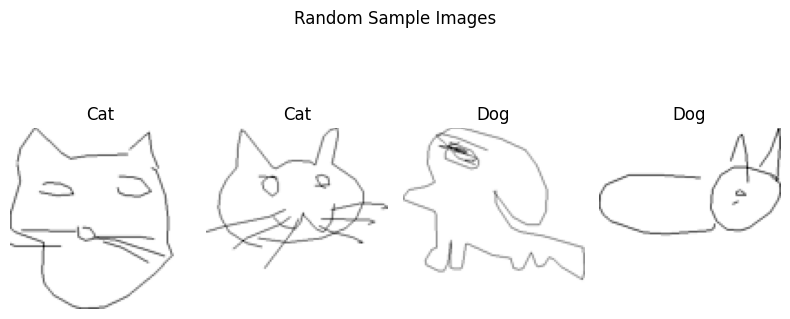

In [2]:
# downloading and visualizing the data - this might take some time!
# preparing the data to feed into the models
X, y = load_doodles_data()

# splitting into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model #1: Logistic Regression

Logistic Regression is a simple yet powerful machine learning model used for classification tasks. It tries to find a decision boundary that separates two classes — in our case, cats and dogs — based on pixel values.

This will serve as our baseline model. Later, we’ll compare its performance with more advanced methods.

Here's a simple picture to think about how Logistic Regression does its job recognizing cats as cats and dogs as dogs. Essentially the logistic regression learns to assign a probability of how likely the image is a cat or a dog, i.e. how "catly" or "dogly" is a given image. Some dog pictures can be more or less "dogly", and some cat pictures can be more or less "catly", but most cat pictures should be more likely to be cats, and most dog pictures should be more likely to be dogs.

![logistic regression](figs/logreg.png)

You can read more about logistic regression [here](https://en.wikipedia.org/wiki/Logistic_regression).

Accuracy: 69.50%


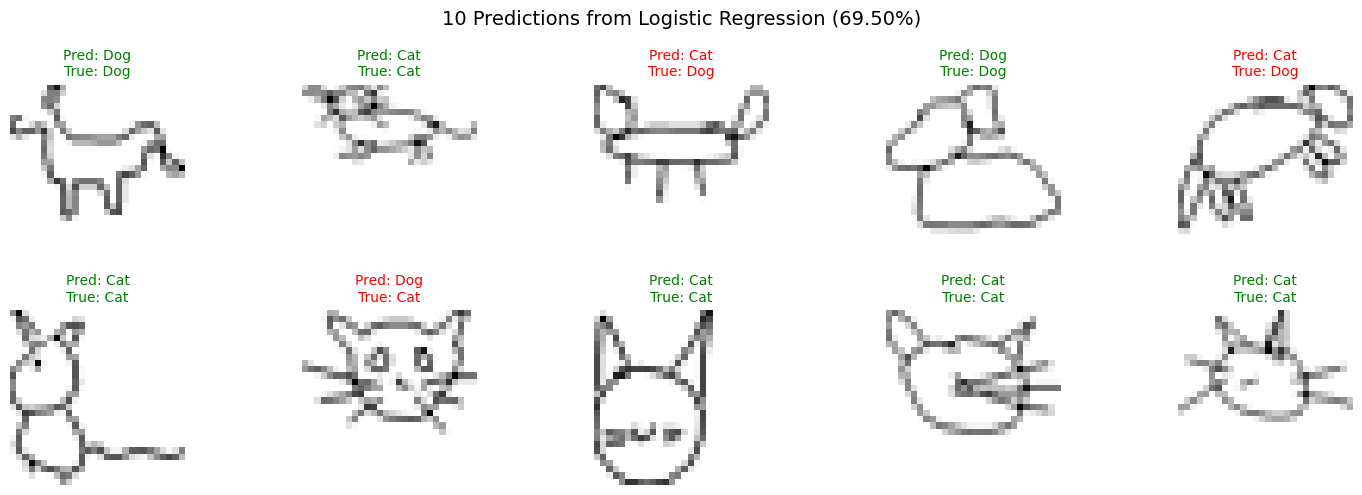

In [3]:
# creating our Logistic Regression model
logreg_model = LogisticRegression()

# feeding our training data to the model
logreg_model.fit(X_train, y_train)

# feeding our test data to the model and getting the accuracy of the model
y_pred = logreg_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")
show_10_random_predictions(X_test, y_test, logreg_model, model_type='sklearn', model_name='Logistic Regression', accuracy=acc * 100, dataset_type='doodles')

So we see that our Logistic Regression model achieves an accuracy between 60-70%. This means that the model can correctly predict whether the image is a doodle of a cat or a dog 60-70% of the time (exact accuracy is what your model outputs). We will now compare these results against two other models.

## Model #2: Support Vector Machine (SVM)

A Support Vector Machine (SVM) is another type of classification model. It works by finding the best boundary that separates two classes of data.

Unlike logistic regression, which models probabilities, an SVM tries to maximize the separation between the two classes. This can make it more effective when the classes are not easily separable with a simple line or curve.

We'll train the SVM on the same data and compare its performance to the logistic regression model.

Again, here's a simple picture to get you thinking about what SVM is going. It also tries to find a boundary between cat and dog data points like Logistic Regression, but also tries to maximize the separation between the boundary, to really confidently say "yes, this is a cat", or "this is really definitely a dog".

![SVM](figs/svm.png)

SVM Accuracy: 67.50%


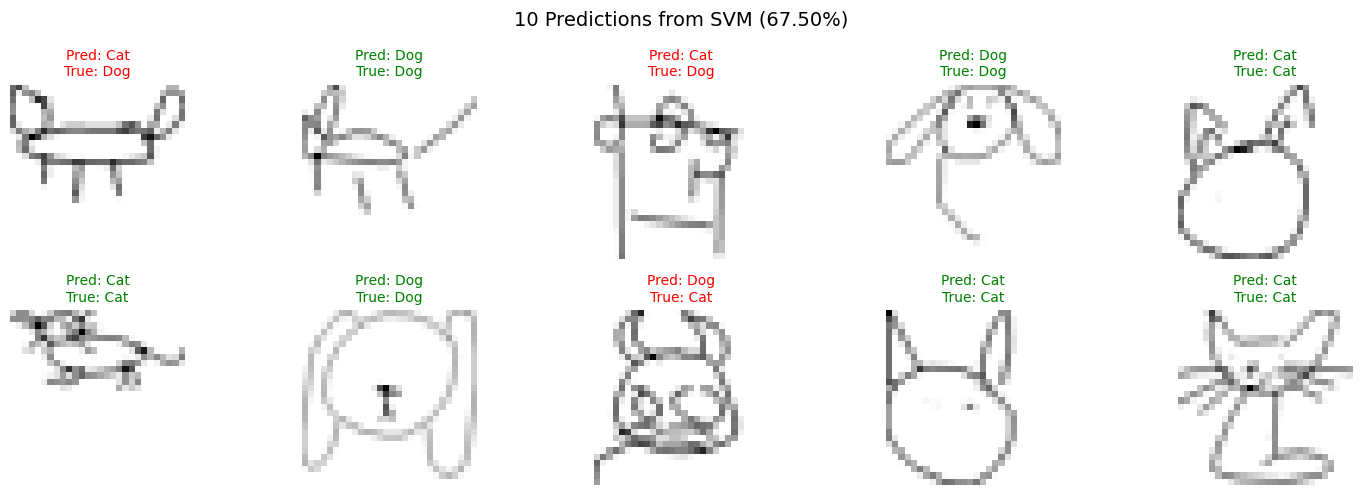

In [4]:
# creating our SVM model
svm_model = SVC(kernel='linear')  

# feeding our training data to the model
svm_model.fit(X_train, y_train)

# feeding our test data to the model and getting the accuracy of the model
y_pred_svm = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_acc * 100:.2f}%")
show_10_random_predictions(X_test, y_test, svm_model, model_type='sklearn', model_name='SVM', accuracy=svm_acc * 100, dataset_type='doodles')

Now we see that our SVM model also achieves an accuracy between 60-70%. This means that the model can correctly predict whether the image is a doodle of a cat or a dog 60-70% of the time (exact accuracy is what your model outputs). We will now compare these results against one more model.

## Model #3: Perceptron

Now we're going to look at a neural network model. A neural network is a type of *deep learning* model that uses layers of connected nodes (called *neurons*) to learn patterns from the data.

Specifically, we're going to look at a *perceptron*, which is one of the simplest types of neural networks. It's like a yes-or-no decision maker.

Think of it like a smart checklist. It looks at every pixel in an image, gives each one a "weight" (how important it is), adds everything up, and if the total is big enough, it says: **“This is a dog!”** Otherwise, it says **“This is a cat!”**

[This is a really great video that explains how perceptrons work](https://www.youtube.com/watch?v=i1G7PXZMnSc).

![perceptron](figs/perceptron.png)

We start by defining the **perceptron model** — think of it like a simple blueprint for how a computer can learn to decide if an image is a **cat** or a **dog**.

A perceptron works like this:

- It takes some **inputs** (like pixels from an image — you can imagine them as $x_1$, $x_2$, etc.).
- Each input has a **weight** (like $w_1$, $w_2$, etc.) that tells the model how important that input is.
- It multiplies each input by its weight and **adds them up**.
- It then applies an **activation function** — this is a rule that says:
  - If the total is big enough, say it's a **dog** (output 1).
  - Otherwise, say it's a **cat** (output 0).

This whole process is like the perceptron "voting" based on the image features. Over time, during training, it **adjusts the weights** so it can make better predictions.

In [5]:
class Perceptron:
    def __init__(self, input_dim, lr=0.001):
        # initialize weights to zero for each input
        self.weights = np.zeros(input_dim)
        # start with no bias
        self.bias = 0
        # set the learning rate (how big of a step we take when updating weights)
        self.lr = lr

    def predict(self, X):
        # calculate the output: weighted sum of inputs plus bias
        linear_output = np.dot(X, self.weights) + self.bias
        # apply step function: if output > 0 → predict 1 (dog), else 0 (cat)
        return (linear_output > 0).astype(int)

    def fit(self, X, y, epochs=10):
        # list to store how accurate the model is after each epoch
        self.accuracies = []

        for epoch in range(epochs):
            correct = 0  # counter for correct predictions

            # go through each training example (xi = input, target = correct label)
            for xi, target in zip(X, y):
                pred = self.predict(xi)  # get prediction
                update = self.lr * (target - pred)  # how much to change weights

                # update the weights and bias
                self.weights += update * xi
                self.bias += update

                # increase correct count if prediction was right
                correct += int(pred == target)

            # calculate accuracy for this epoch
            acc = correct / len(y)
            self.accuracies.append(acc)
            print(f"Epoch {epoch+1}/{epochs} - Accuracy: {acc * 100:.2f}%")

Now we will train our model by feeding it the training data. We will train the model 5 times (called an 'epoch') and track how well it's learning the differences between cat and dog during this process.

Epoch 1/5 - Accuracy: 53.12%
Epoch 2/5 - Accuracy: 53.00%
Epoch 3/5 - Accuracy: 53.00%
Epoch 4/5 - Accuracy: 53.00%
Epoch 5/5 - Accuracy: 53.00%


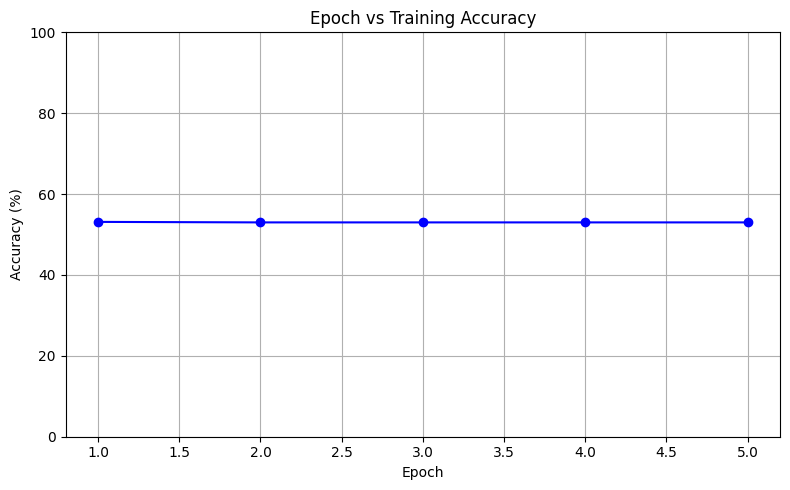

In [6]:
input_dim = X_train.shape[1]
perceptron = Perceptron(input_dim=input_dim)
perceptron.fit(X_train, y_train, epochs=5)
plot_accuracy_curve(perceptron.accuracies, title="Epoch vs Training Accuracy")

With the model trained, the next step is to test how well it learned the differences between cat and dog by feeding it new images of cats and dogs which it has never seen before.

Test Accuracy: 50.50%


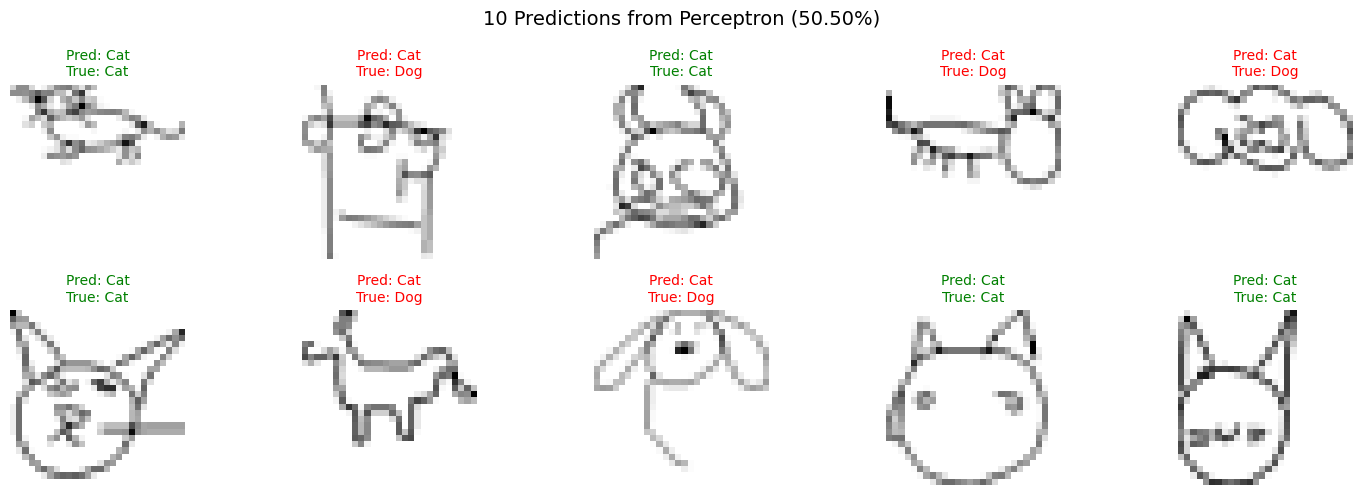

In [7]:
# Evaluate on test set
y_pred = perceptron.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")
show_10_random_predictions(X_test, y_test, perceptron, model_type='sklearn', model_name='Perceptron', accuracy=acc * 100, dataset_type='doodles')

We see that the perceptron achieves around 50% accuracy. This means it's performing like a coin flip - a random guess at either cat or dog. This isn't surprising - image data is usually quite complex and it takes more than a single layer of neurons to be able to learn the features in an image. 

We will now explore another type of neural network - a deep neural network called ResNet.

## Model #4: Neural Network (Simple ResNet)

Neural networks are *powerful* models that learn by stacking layers of computations. A ResNet, short for Residual Network, is a type of deep neural network that is widely used by ML practitioners as a standard benchmark model. See [this](https://en.wikipedia.org/wiki/Residual_neural_network) if you're interested in learning more about ResNet!

In this notebook, we use a very simple version of a ResNet. It includes convolutional layers that detect patterns in the images, and a residual block that helps the model learn more complex features without losing important information.

We'll train this network using [PyTorch](https://pytorch.org/), a deep learning library widely used in both research and industry. Then, we'll compare its accuracy to the other models.

We start by preparing the data specially for this model, as it requires a different format than what we've used for Logistic Regression and SVM. Again, we have pre-written a program in `utils.py` that takes care of the data pre-processing for you.

In [8]:
# preparing the data to feed to the ResNet
train_loader, test_loader = preprocess_pytorch_data(X, y)

Now we have to define the model architecture. This is like writing a recipe for a cake, where the cake is our neural network, and we write down what ingredinents go into baking this cake and in what order. We have drawn a simple version of what this model architecture looks like, but don't worry about the details - think of the ResNet as a food processor which takes in your image (which is either a cat or a dog), does some stuff (learns features from the image through computations), and then finally outputs a prediction: either 0 if the model thinks the image is a cat, or 1 if the model think the image is a dog.

Here's a simple visualization of the ResNet architecture, where it takes in the image, runs the image through layers of computations, and outputs a prediction.

![simple ResNet](figs/simple_resnet.png)

At each layer, the computation is called a 'convolution', which means a lot of matrix multiplication. This is a visualization of how the convolution process works.

![convolution](figs/cnn_viz.gif)

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity  # Residual connection
        out = self.relu(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, in_channels=1):
        """
        Args:
            in_channels (int): Number of input channels (1 for doodles, 3 for CIFAR)
        """
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.resblock = ResidualBlock(16)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16, 2)  # 2 classes (cat/dog)
    
    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.resblock(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Now with the model architecture defined, we will start setting the scene for training our model.

In [10]:
# set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating our ResNet model from the architecture defined above
model = SimpleResNet(in_channels=1).to(device)

# defining a "loss function" that helps the model learn patterns from the images
criterion = nn.CrossEntropyLoss()

# defining an "optimizer" that also helps the model learn patterns
optimizer = optim.Adam(model.parameters(), lr=0.001)

Now with everything set in place, we train the ResNet model in a 'training loop'. We feed the data through the neural network 5 times (also called 'epochs') to help it learn complex patterns from the data.

Epoch 1/5 - Accuracy: 50.62%
Epoch 2/5 - Accuracy: 58.50%
Epoch 3/5 - Accuracy: 65.50%
Epoch 4/5 - Accuracy: 66.50%
Epoch 5/5 - Accuracy: 72.12%


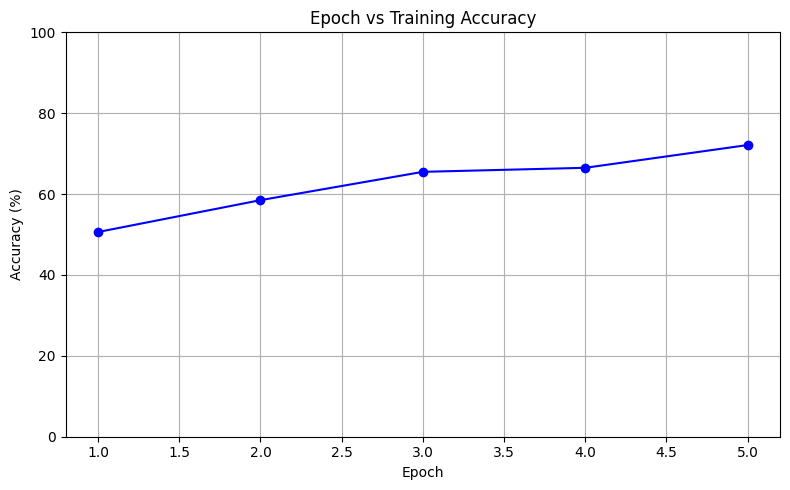

In [11]:
train_accuracies = []

# Training loop
epochs = 5  # adjust as needed
model.train()

for epoch in range(epochs):
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_acc = correct / total
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} - Accuracy: {epoch_acc * 100:.2f}%")

# Plotting epoch vs accuracy
plot_accuracy_curve(train_accuracies, title="Epoch vs Training Accuracy")

Now that we have trained the model, we will feed it the test data, and see how well it can perform.

Simple ResNet Test Accuracy: 47.50%


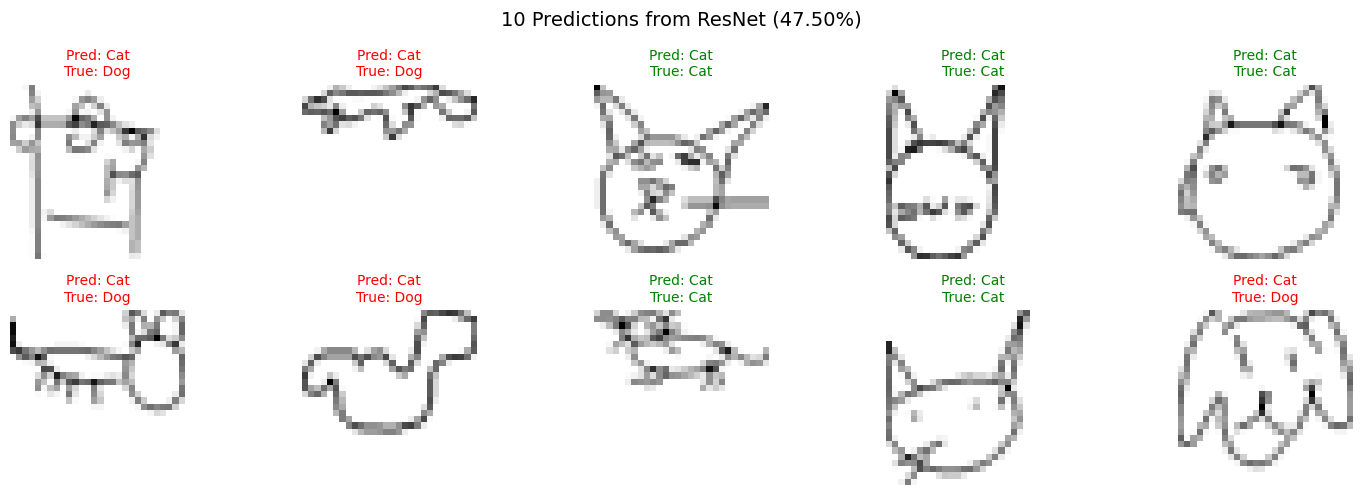

In [12]:
# Evaluation on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# calculating accuracy and displaying model's predictions
accuracy = 100 * correct / total
print(f"Simple ResNet Test Accuracy: {accuracy:.2f}%")
show_10_random_predictions(X_test, y_test, model, model_type='resnet', model_name='ResNet', accuracy=accuracy, dataset_type='doodles')  # model is your PyTorch model

## Why Did the ResNet Perform Worse?

Even though neural networks like ResNet are more powerful and flexible, they don't always perform better — especially on small or simple datasets like ours.

There are a few reasons why the ResNet may have lower accuracy than the logistic regression and SVM models:

- The dataset is small (only 1,000 images total), which makes it harder for deep models to learn effectively.
- Neural networks have a lot more parameters and need more data to generalize well.
- Our ResNet was trained for just a few epochs and kept very simple for this workshop. A more complex version with more layers and training time might perform better.
- Simpler models like logistic regression and SVM often work surprisingly well when the input features (pixel patterns) are already quite informative.

This is an important lesson in AI: sometimes, **simpler models are better suited to the problem** — especially when data is limited. But for large, complex datasets (like natural photos or videos), deep neural networks usually shine.

Note here that the ResNet model achieves around ~50% accuracy. This means it's randomly guessing what the image is - either it will be a cat or a dog. This is like when you flip a coin and you can guess correctly if it's heads or tails 50% of the time.

Also note that we only trained our model here for 5 epochs. What happens if we increase that number? We ran that experiment for you, here are the results when we train the model for 10,000 epochs on a powerful GPU.

We find that the accuracy starts low, around 55%, but then slowly starts increasing to or near 100%, stabilizing around the 200th epoch. This means the model has learned meaningul features by the 200th epoch, enough to be correctly training the model.

![trained for 10000 epochs](figs/01_doodles_acc.png)

But what happens when we test our model on the test images? We find that it achieves a higher accuracy than our 5 epoch-trained model, 72%. This shows us that more time training the model on the same small dataset *does* help in increasing the accuracy a little bit.

![tested on 50 images](figs/02_doodles_test.png)

## Conclusion

In this notebook, we explored how artificial intelligence can be used to recognize hand-drawn doodles. We trained and tested four different models: logistic regression, support vector machine (SVM), a perceptron neural network, and a simple neural network based on the ResNet architecture.

Along the way, we learned how to prepare image data, train models, and evaluate their performance. We also saw how even simple models can perform well on visual tasks, and how more advanced models like neural networks can capture more complex patterns.

This hands-on activity is just the beginning. The same ideas used here are part of how modern AI systems recognize faces, understand handwriting, power self-driving cars, and more. With practice and curiosity, you can keep exploring and building even more powerful AI models.


================================================================================
================================================================================

## Bonus Content! Classifying Real Images

We just classified *doodles* of cats and dogs using three models (Logistic Regression, SVM, ResNet). But what if we now use *real images* of cats and dogs? Isn't that exciting?

We'll be using the [CIFAR-10 dataset](https://en.wikipedia.org/wiki/CIFAR-10), which is a famous benchmark dataset of images used in machine learning. There's 10 different classes of images: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. But we're going to use a small subset of cats and dogs only. 

We'll do the same thing as before, which is pre-processing the data, and training Logistic Regression, SVM, and ResNet models on it.

100%|██████████| 170M/170M [00:17<00:00, 9.80MB/s] 


Download complete.


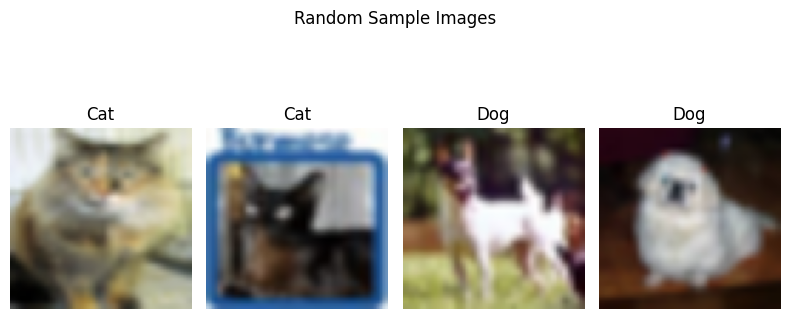

In [13]:
# downloading and visualizing the data - this might take some time!
# preparing the data to feed into the models
X, X_flat, y = load_cifar10_cats_and_dogs()

# splitting into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2)

WHOA!?!? Why do these images look so...blurry? 

Our laptops often aren't powerful enough (as in, they don't have enough memory and GPU compute power) to handle processing very large datasets. So to keep a light load on your laptops, we are doing 2 things:
1. using a smaller subset of cats and dogs data - 200 images per class.
2. using a lower resolution.

These images are originally 32x32 pixels (and in color!), however for this workshop, we have lowered the resolution to 28x28 pixels. This is what makes these pictures look blurry. Don't worry - let's see what happens! Will our models be able to recognize these cats as cats and dogs as dogs? Only one way to find out!

## Model #1: Logistic Regression

Let's run these images through a new Logistic Regression model.

Accuracy: 55.00%


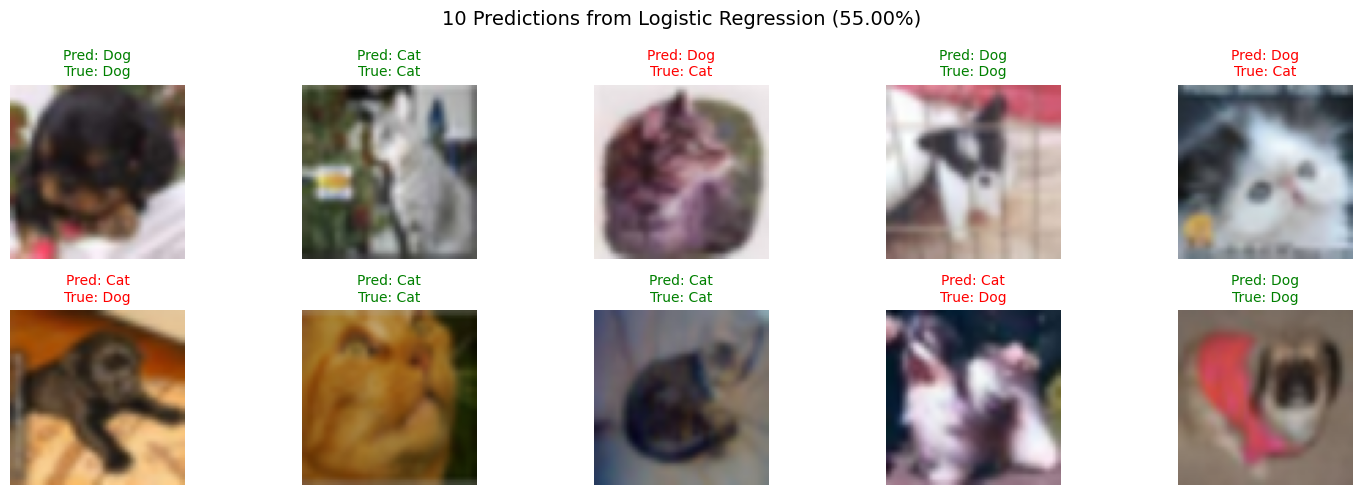

In [14]:
# creating our Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)

# feeding our training data to the model
logreg_model.fit(X_train, y_train)

# feeding our test data to the model and getting the accuracy of the model
y_pred = logreg_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")
show_10_random_predictions(X_test, y_test, logreg_model, model_type='sklearn', model_name='Logistic Regression', accuracy=acc * 100, dataset_type='cifar')

## Model #2: Support Vector Machine (SVM)

Again, we'll repeat the experiment for SVM...

SVM Accuracy: 52.50%


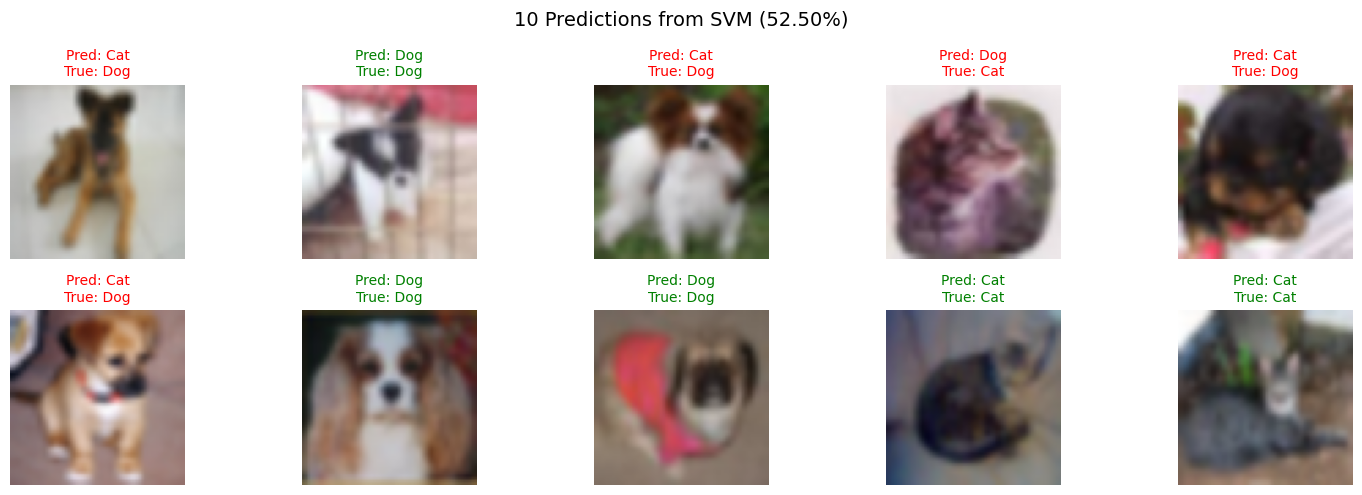

In [15]:
# creating our SVM model
svm_model = SVC(kernel='linear')  

# feeding our training data to the model
svm_model.fit(X_train, y_train)

# feeding our test data to the model and getting the accuracy of the model
y_pred_svm = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_acc * 100:.2f}%")
show_10_random_predictions(X_test, y_test, svm_model, model_type='sklearn', model_name='SVM', accuracy=svm_acc * 100, dataset_type='cifar')

## Model #3: Neural Network (Simple ResNet)

Finally, we'll train our deep neural network, Simple ResNet. Note that we have to pre-process the data to get it into a format the neural network can work with, but we've taken care of that for you, so you just need to run the code!

In [16]:
# splitting into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
train_loader, test_loader = preprocess_pytorch_data(X, y)

We don't have to define the architecture of the ResNet again, since it has already been defined earlier and we're not making any changes to the model architecture. We will need to re-instantiate the model, loss function, and optimizer, however.

In [17]:
# set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating our ResNet model from the architecture defined above
model = SimpleResNet(in_channels=3).to(device)

# defining a "loss function" that helps the model learn patterns from the images
criterion = nn.CrossEntropyLoss()

# defining an "optimizer" that also helps the model learn patterns
optimizer = optim.Adam(model.parameters(), lr=0.001)

Once again, we now start to train the model with the cats and dogs images.

Epoch 1/5 - Accuracy: 52.19%
Epoch 2/5 - Accuracy: 55.00%
Epoch 3/5 - Accuracy: 56.56%
Epoch 4/5 - Accuracy: 63.75%
Epoch 5/5 - Accuracy: 64.38%


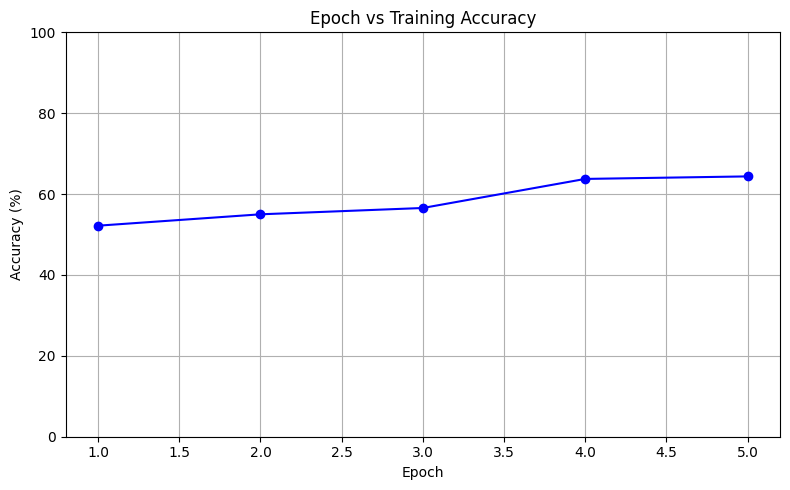

In [18]:
train_accuracies = []

# Training loop
epochs = 5  # adjust as needed
model.train()

for epoch in range(epochs):
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_acc = correct / total
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} - Accuracy: {epoch_acc * 100:.2f}%")

# Plotting epoch vs accuracy
plot_accuracy_curve(train_accuracies, title="Epoch vs Training Accuracy")

And final touches...*test* the model to see how well it learned to recognize cat and dog pictures!

Simple ResNet Test Accuracy: 71.25%


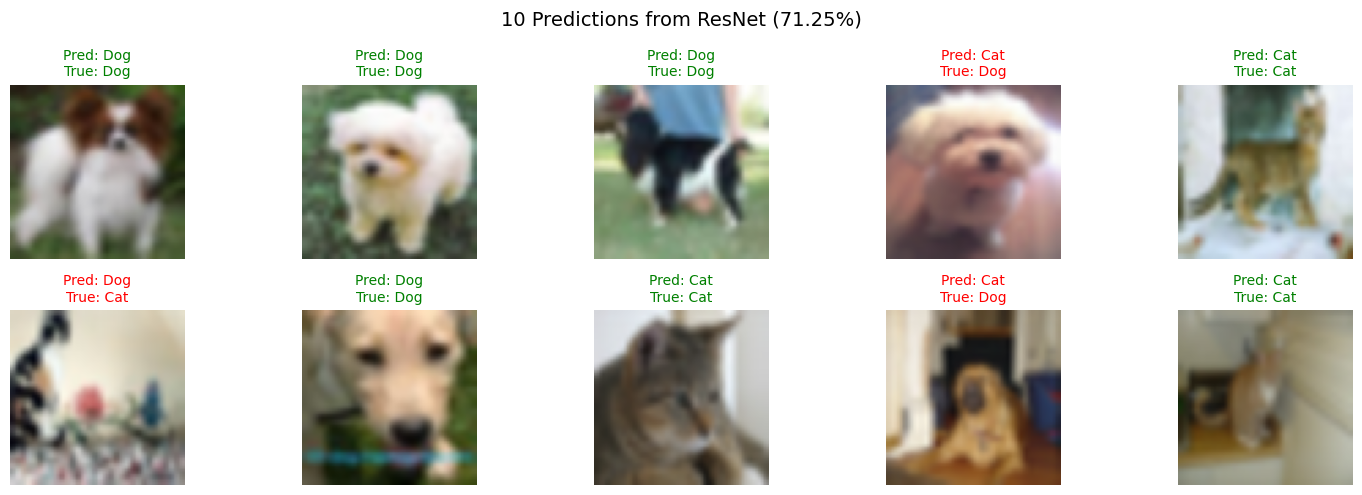

In [19]:
# Evaluation on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# calculating accuracy and displaying model's predictions
accuracy = 100 * correct / total
print(f"Simple ResNet Test Accuracy: {accuracy:.2f}%")
show_10_random_predictions(X_test, y_test, model, model_type='resnet', model_name='ResNet', accuracy=accuracy, dataset_type='cifar')  # model is your PyTorch model

![trained for 10000 epochs](figs/03_cifar_acc.png)
![tested on 50 images](figs/04_cifar_test.png)

**Exercise for you:** check the accuracies for each of the models you just ran (Logistic Regression, SVM, ResNet) on this CIFAR-10 cats and dogs dataset, with the same models you ran for the Doodles dataset. 

- Which model, out of the 6, performed the best?
- Did the models trained on the different datasets perform comparably?
- What do you think of the difference in performances between the models and datasets? 

Remember the difference between both datasets - the Doodles dataset is a very simple black-and-white dataset of doodles, wheareas the CIFAR-10 dataset is a color dataset of pictures of real cats and dogs, which contains more information.